In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split


In [20]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pymatching
import json

def plotter(idx_list, color, marker="o"):
    for idx in (idx_list):
        # print(idx, idx_list[f"{idx}"])
        x, y = idx_list[idx]
        plt.plot(x,y,marker= marker,markersize=10,markerfacecolor="None",markeredgecolor=color)
        plt.text(x,y,idx)

# Function to create the modified arrays
def create_parts(array, part_size):
    parts = []
    for i in range(4):
        part_array = np.zeros_like(array)
        start_index = i * part_size
        end_index = start_index + part_size
        part_array[start_index:end_index] = array[start_index:end_index]
        parts.append(part_array)
    return parts

def q_func(d,t,r,c,i):
    # qubit indices as defined in the paper
    return int(((d-1)/2+r*(i+1)+1)*(t*d+(1-t)) -1 + 2*c*(d*(1-t)-t))
def a_func(d,t,r,c,i):
# ancilla indices as defined in the paper
    return int((d**2-1)/4*(1+2*t) + ((r-1)/2+r*i)*(d+1)/2 +c )

def idx_to_coord(d):
    """
    This is to keep track of index assignment to data and ancilla qubits
    c.f. Figure 9 of arXiv:2202.05741
    """
    q_list = {}
    sz_list = {}
    c_sz = (d**2-1)-1
    for row in range(d):
        for col in range(d):
            x, y = col-(d-1)/2, row-(d-1)/2
            q_list[f"{d**2-d+col-d*row}"] = (x,y)
            if row %2 ==1 and col % 2 == 0:
                x_sz, y_sz = x+0.5, y+ 0.5
                sz_list[f"{c_sz}"] = (x_sz, y_sz)
                c_sz -= 1
            if row %2 ==0 and col % 2 == 0 and row < d-1:
                x_sz, y_sz = x-0.5, y+ 0.5
                sz_list[f"{c_sz}"] = (x_sz, y_sz)
                c_sz -= 1

    c_q = 0
    sx_list = {}
    c_sx = 0# (d**2-1)-1
    for col in range(d):
        for row in range(d):
            x, y = col-(d-1)/2, (d-1)/2-row
            if row %2 ==0 and col % 2 == 1:
                x_s, y_s = x+0.5, y- 0.5
                sx_list[f"{c_sx}"] = (x_s, y_s)
                c_sx += 1
            if row %2 ==0 and col % 2 == 0 and col < d-1:
                x_s, y_s = x+0.5, y+ 0.5
                sx_list[f"{c_sx}"] = (x_s, y_s)
                c_sx += 1
    return q_list, sx_list, sz_list

def code_initialization(d):
    """
        Calculate necessary mappings from qubit indices to qubit location,
        stabilizer matrix
        logical operator matrix
        input:
            d :int  surface code distance
        output:
            s_mat : X, Z stabilizer matrix
            logicals : X, Z logical operator matrix
    """
    c_list = np.arange((d+1)//2) # c as defined in the paper
    x_stab_to_c = np.zeros((d**2-1)//2,dtype=int)
    t = 0
    for r in [-1,1]:
        for c in c_list:
            for i in range((d-1)//2 ):
                x_stab_to_c[a_func(d,t,r,c,i)] = c

    z_stab_to_c = np.zeros((d**2-1)//2,dtype=int)
    t = 1
    for r in [-1,1]:
        for c in c_list:
            for i in range((d-1)//2 ):
                z_stab_to_c[a_func(d,t,r,c,i)-(d**2-1)//2] = c

    q_list, sx_list, sz_list = idx_to_coord(d)

    # define stabilizers 
    s_mat = np.zeros(((d**2-1), 2*d**2))
    for sx in sx_list:
        r_sx = sx_list[sx]
        for q in q_list:
            r_q = q_list[q]
            if (r_q[0]-r_sx[0])**2+(r_q[1]-r_sx[1])**2 < 1:
                # print(sx,q)
                s_mat[int(sx),int(q)] = 1

    for sz in sz_list:
        r_sz = sz_list[sz]
        for q in q_list:
            r_q = q_list[q]
            if (r_q[0]-r_sz[0])**2+(r_q[1]-r_sz[1])**2 < 1:
                # print(sx,q)
                s_mat[int(sz),d**2+ int(q)] = 1

    # define logical operators
    logicals = np.zeros((2,2*d**2))
    logicals[0,np.arange(0,d**2,d)]= 1 # x logical
    logicals[1,d**2+np.arange(d**2-d, d**2)]= 1 # z logical

    stab_matrices = (x_stab_to_c,z_stab_to_c,sx_list,sz_list)
    return stab_matrices, s_mat, logicals

class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x



In [21]:
def generate_date(i_d,d,i_p, p_err,storing_baseline_results_flag):
    global global_counter
    global testing_data_structure
    X = [] # we use X to store the list of syndrome
    y = [] # we use y to store the label of each syndrome: 1 which means this syndrome can be divided by two and run in parallel or 0 otherwise
    
    print(f"code dist: {d}")
    tic = time.time()
    logical_err = np.zeros((p_err_list.shape[0],len(d_list)))
    q_list, sx_list, sz_list = idx_to_coord(d)
    stab_matrices, s_mat, logicals = code_initialization(d)
    x_stab_to_c,z_stab_to_c,sx_list,sz_list = stab_matrices
    weights = np.ones(d**2) * np.log((1-0.15)/0.15)
    ind = (d**2-1)//2
    matching_x = pymatching.Matching(s_mat[:ind,:d**2],spacelike_weights=weights)
    matching_z = pymatching.Matching(s_mat[ind:,d**2:],spacelike_weights=weights)
    pauli = [0,1,2,3] # I X Z Y
    counter_parallel = 0
    counter = 0
    for iter in range(Niter):
        err_instance = np.array(random.choices(pauli, [1-p_err,p_err/3,p_err/3,p_err/3], k=d**2))
        x_err = np.argwhere(err_instance==1)[:,0]
        z_err = np.argwhere(err_instance==2)[:,0]
        y_err = np.argwhere(err_instance==3)[:,0]
        # print(z_err)
        # print(err_instance)

        err_vec = np.zeros(2*d**2)
        if len(x_err)> 0:
            err_vec[x_err] = 1
        if len(z_err)> 0:
            err_vec[d**2 + np.array(z_err)] = 1
        if len(y_err)> 0:
            err_vec[y_err] = 1
            err_vec[d**2 + np.array(y_err)] = 1
        each_data_indx_err_vector.append(err_vec)
        global_counter+=1
        comm_mat = np.kron([[0,1],[1,0]],np.eye(d**2))
        syndrome = (s_mat@ (comm_mat @err_vec)) % 2
        K = len(syndrome)

        syndrome_x = syndrome[:ind]
        syndrome_z = syndrome[ind:]
        recovery_x = matching_x.decode(syndrome_x)
        recovery_z = matching_z.decode(syndrome_z)

        #print("recovery_x",len(recovery_x),recovery_x)
        # print("recovery_z",len(recovery_z),recovery_z)
        idx_recovery_z = np.argwhere(recovery_z>0)[:,0]
        idx_recovery_x = np.argwhere(recovery_x>0)[:,0]
        err_rec = np.copy(err_vec)
        err_rec[idx_recovery_z] += 1
        err_rec[d**2 + idx_recovery_x] += 1
        err_rec %= 2

        # Determine the size of each part
        n = len(syndrome_x)
        part_size = n // 2
        # Create the modified arrays
        parts = create_parts(syndrome_x, part_size)
        # Print the original array and the parts
        # print("Original Array:",part_size)
        #print(original_array)
        recovery_x = np.zeros(len(recovery_x))
        recovery_z = np.zeros(len(recovery_z))
        for i, part in enumerate(parts):
            s_t = time.time()
            recovery_x_part = matching_x.decode(part)
            e_t = time.time()
            #print("part %s recovery_x_part %s "%(i,recovery_x_part))
            recovery_x = recovery_x+recovery_x_part%2
            # print("counter_parallel",counter_parallel,len(parts))
            #print("after sum %s recovery_x %s "%(i,recovery_x))
        # Create the modified arrays
        parts = create_parts(syndrome_z, part_size)
        for i, part in enumerate(parts):
            s_t = time.time()
            recovery_z_part = matching_z.decode(part)
            e_t = time.time()
            # print("counter_parallel",counter_parallel,len(parts))
            # print("part %s recovery_x_part %s "%(i,recovery_z_part))
            recovery_z = recovery_z+recovery_z_part%2
        # print("parallel recovery_x",len(recovery_x),recovery_x)
        # print("parallel recovery_z",len(recovery_z),recovery_z)
        
        
        idx_recovery_z = np.argwhere(recovery_z>0)[:,0]
        idx_recovery_x = np.argwhere(recovery_x>0)[:,0]

        err_rec_parallel = np.copy(err_vec)
        err_rec_parallel[idx_recovery_z] += 1
        err_rec_parallel[d**2 + idx_recovery_x] += 1
        err_rec_parallel %= 2
        # print(syndrome.shape,type(syndrome),syndrome.tolist())
        X.append(syndrome.tolist())
        if np.array_equal(err_rec_parallel,err_rec):
            each_code_parallel_decoding_match[i_d]+=1
            y.append([1.0])
        else:
            y.append([0.0])
        logical_err[i_p,i_d] += np.sum(logicals@ (comm_mat @ err_rec) % 2)>0

        print("done d %s p_err %s  / %s %s from %s counter_parallel %s counter %s "%(d,i_p,len(p_err_list),iter,Niter,counter_parallel,counter),end = "\r")
    if storing_baseline_results_flag:
        logical_err[i_p,i_d] /= Niter
        try:
            testing_data_structure[i_d][i_p] = logical_err[i_p,i_d]
        except:
            testing_data_structure[i_d] = {}
            testing_data_structure[i_d][i_p] = logical_err[i_p,i_d]
    toc = time.time()
    print(f"Finished in {toc-tic} sec.")
    return X,y,K
def get_train_test_loader(X,y,train_percentage,batch_size):
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.float32)
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X)
    y_tensor = torch.tensor(y)
    # Create a dataset and data loader
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(train_percentage * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_loader,test_loader

In [22]:
# K=10
global_counter = 0
num_epochs = 20
p_err_list = np.arange(0.02,0.21,0.05)
print("p_err_list",p_err_list)
Niter = 100000
d_list = [7,9]
each_code_parallel_decoding_match = np.zeros((len(d_list),1))
each_code_proecssing_time = np.zeros(Niter+1)
logical_err_baseline = np.zeros((len(d_list),p_err_list.shape[0]))
logical_err_parallel = np.zeros((len(d_list),p_err_list.shape[0]))
decoding_time_parallel=np.zeros((len(d_list),p_err_list.shape[0]))
decoding_time_baseline=np.zeros((len(d_list),p_err_list.shape[0]))
logical_err_parallel_data= {}
logical_err_baseline_data = {}
testing_data_structure = {}

p_err_list [0.02 0.07 0.12 0.17]


In [ ]:
for i_d, d in enumerate(d_list):
    print(f"code dist: {d}")
    tic = time.time()
    data_list = {}
    data_list_parallel = {}
    JSON_PATH = f"results/mwpm_sweep_d_{d}.json"
    data_list["p_err"] = p_err_list.tolist()
    q_list, sx_list, sz_list = idx_to_coord(d)
    stab_matrices, s_mat, logicals = code_initialization(d)
    x_stab_to_c,z_stab_to_c,sx_list,sz_list = stab_matrices
    p_err = 0.15
    weights = np.ones(d**2) * np.log((1-p_err)/p_err)
    ind = (d**2-1)//2
    matching_x = pymatching.Matching(s_mat[:ind,:d**2],spacelike_weights=weights)
    matching_z = pymatching.Matching(s_mat[ind:,d**2:],spacelike_weights=weights)

    pauli = [0,1,2,3] # I X Z Y
    for i_p, p_err in enumerate(p_err_list):
        s_t = time.time()
        each_data_indx_err_vector = []
        global_counter  =0
        X,y,K = generate_date(i_d,d,i_p, p_err,False)
        global_counter = 0
        train_loader,test_loader = get_train_test_loader(X,y,0.8,32)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = BinaryClassifier(input_size=K).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        
        
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
                running_loss += loss.item()
        
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}',end="\r")



        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # print(inputs[0].shape, labels[0].shape)
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        print(f'Accuracy: {accuracy * 100:.2f}%')


        each_data_indx_err_vector = []
        X,y,K = generate_date(i_d,d,i_p, p_err,True)
        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X)
        y_tensor = torch.tensor(y)
        
        # Create a dataset and data loader
        # print("X_tensor",X_tensor)
        dataset = TensorDataset(X_tensor, y_tensor)
        # Use the entire dataset as test dataset
        test_dataset = dataset
        # Optionally, create a DataLoader for the test dataset
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        # print("test_loader",test_loader)




        model.eval()
        counter = 0
        data_indx = 0
        # print(len(test_loader))
        with torch.no_grad():
            for inputs, labels in test_loader:
                # print(len(inputs),inputs)
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                syndrome = inputs[0]
                err_vec = each_data_indx_err_vector[data_indx]
                data_indx+=1
                comm_mat = np.kron([[0,1],[1,0]],np.eye(d**2))
                syndrome = (s_mat@ (comm_mat @err_vec)) % 2
                K = len(syndrome)
                syndrome_x = syndrome[:ind]
                syndrome_z = syndrome[ind:]
                baseline_decoding_times = []
                parallel_decoding_times = []
                # print("error is ",err_vec)
                # print("syndrome is ",syndrome)
                label_value = outputs.item()
                # print("label is ", label_value)
                s_t = time.time()
                recovery_x = matching_x.decode(syndrome_x)
                e_t = time.time()
                baseline_decoding_times.append(e_t-s_t)
                s_t = time.time()
                recovery_z = matching_z.decode(syndrome_z)
                e_t = time.time()
                baseline_decoding_times.append(e_t-s_t)
        
                #print("recovery_x",len(recovery_x),recovery_x)
                # print("recovery_z",len(recovery_z),recovery_z)
                idx_recovery_z = np.argwhere(recovery_z>0)[:,0]
                idx_recovery_x = np.argwhere(recovery_x>0)[:,0]
        
                err_rec = np.copy(err_vec)
                err_rec[idx_recovery_z] += 1
                err_rec[d**2 + idx_recovery_x] += 1
                err_rec %= 2
                if label_value>0.5:
                    # print("we are dividing!")
                    # Determine the size of each part
                    n = len(syndrome_x)
                    part_size = n // 2
                    # Create the modified arrays
                    parts = create_parts(syndrome_x, part_size)
                    
                    recovery_x = np.zeros(d**2)
                    recovery_z = np.zeros(d**2)
                    for i, part in enumerate(parts):
                        s_t = time.perf_counter()
                        recovery_x_part = matching_x.decode(part)
                        e_t = time.perf_counter()
                        parallel_decoding_times.append(e_t-s_t)
                        #print("part %s recovery_x_part %s "%(i,recovery_x_part))
                        recovery_x = recovery_x+recovery_x_part%2
                    # Create the modified arrays
                    parts = create_parts(syndrome_z, part_size)
                    for i, part in enumerate(parts):
                        s_t = time.perf_counter()
                        recovery_z_part = matching_z.decode(part)
                        e_t = time.perf_counter()
                        parallel_decoding_times.append(e_t-s_t)
                        
                        recovery_z = recovery_z+recovery_z_part%2
                    
                idx_recovery_z = np.argwhere(recovery_z>0)[:,0]
                idx_recovery_x = np.argwhere(recovery_x>0)[:,0]
        
                err_rec_parallel = np.copy(err_vec)
                err_rec_parallel[idx_recovery_z] += 1
                err_rec_parallel[d**2 + idx_recovery_x] += 1
                err_rec_parallel %= 2
                #print("adding syndrome to X ",type(syndrome),syndrome.shape,syndrome)
                # print(syndrome.shape,type(syndrome),syndrome.tolist())
                
                if label_value>0.5:
                    logical_err_parallel[i_d,i_p] += np.sum(logicals@ (comm_mat @ err_rec_parallel) % 2)>0
                    decoding_time_parallel[i_d,i_p] = max(parallel_decoding_times)
                else:
                    logical_err_parallel[i_d,i_p] += np.sum(logicals@ (comm_mat @ err_rec) % 2)>0
                    decoding_time_parallel[i_d,i_p] = max(baseline_decoding_times)

                logical_err_baseline[i_d,i_p] += np.sum(logicals@ (comm_mat @ err_rec) % 2)>0
                decoding_time_baseline[i_d,i_p] = max(baseline_decoding_times)
        logical_err_parallel[i_d,i_p] /= data_indx
        logical_err_baseline[i_d,i_p] /= data_indx
        
        try:
            logical_err_parallel_data[i_d][i_p] = logical_err_parallel[i_d,i_p]
        except:
            logical_err_parallel_data[i_d] ={} 
            logical_err_parallel_data[i_d][i_p] = logical_err_parallel[i_d,i_p]
        
        try:
            logical_err_baseline_data[i_d][i_p] = logical_err_baseline[i_d,i_p]
        except:
            logical_err_baseline_data[i_d] ={} 
            logical_err_baseline_data[i_d][i_p] = logical_err_baseline[i_d,i_p]
        t_d = time.time()-s_t
        print("done for d %s / %s physical error %s / %s in %s seconds "%(i_d,len(d_list),i_p,len(p_err_list),t_d))
        
        


code dist: 7
code dist: 7
Finished in 56.881802558898926 sec.0000 counter_parallel 0 counter 0 
Accuracy: 99.74%oss: 0.0007
code dist: 7
Finished in 54.632383823394775 sec.0000 counter_parallel 0 counter 0 
done for d 0 / 2 physical error 0 / 4 in 1716569610.860311 seconds 
code dist: 7
Finished in 55.969005823135376 sec.0000 counter_parallel 0 counter 0 
Accuracy: 97.33%oss: 0.0156
code dist: 7


In [17]:
print(decoding_time_baseline)

[[2.07424164e-05 2.14576721e-05 2.07424164e-05 2.28881836e-05]
 [2.05039978e-05 2.26497650e-05 2.26497650e-05 2.67028809e-05]]


In [9]:
from numpy import savetxt
# JSON_PATH_logical_err_parallel=f"results/JSON_PATH_logical_err_parallel.csv"
# JSON_PATH_decoding_time_parallel=f"results/JSON_PATH_decoding_time_parallel.csv"
# JSON_PATH_logical_err_baseline=f"results/JSON_PATH_logical_err_baseline.csv"
# JSON_PATH_decoding_time_baseline = f"results/JSON_PATH_decoding_time_baseline.csv"
# # we store the x-axis and y-axis for each distance (d value) in a JSON format
# savetxt(JSON_PATH_logical_err_parallel, logical_err_parallel, delimiter=',')
# savetxt(JSON_PATH_decoding_time_parallel, decoding_time_parallel, delimiter=',')
# savetxt(JSON_PATH_logical_err_baseline, logical_err_baseline, delimiter=',')
# savetxt(JSON_PATH_decoding_time_baseline, decoding_time_baseline, delimiter=',')




#load numpy array from csv file
# from numpy import loadtxt
# load array
# logical_err_parallel = loadtxt(JSON_PATH_logical_err_parallel, delimiter=',')
# decoding_time_parallel = loadtxt(JSON_PATH_decoding_time_parallel, delimiter=',')
# logical_err_baseline = loadtxt(JSON_PATH_logical_err_baseline, delimiter=',')
# decoding_time_baseline = loadtxt(JSON_PATH_decoding_time_baseline, delimiter=',')




In [11]:
logical_err_parallel

[]

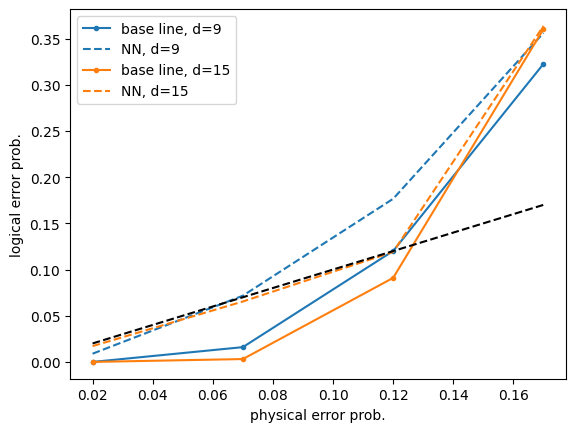

In [17]:
for i_d, d in enumerate(d_list):
    logical_err = []
    logical_err_parallel = []
    for i_p, p_err in  enumerate(p_err_list):
        #print(logical_err_parallel)
        logical_err.append(logical_err_baseline_data[i_d][i_p])
        logical_err_parallel.append(logical_err_parallel_data[i_d][i_p])
    plt.plot(p_err_list,logical_err,".-", color= f"C{i_d}",label=f"base line, d={d}")
    # print(p_err_list,logical_err)
    plt.plot(p_err_list,logical_err_parallel,"--", color= f"C{i_d}",label=f"NN, d={d}")
    # print("parallel",p_err_list,logical_err_parallel)
plt.plot(p_err_list,p_err_list,"k--")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()
plt.show()

In [22]:
print("decoding_time_baseline",decoding_time_baseline)

decoding_time_baseline [[2.07424164e-05 2.14576721e-05 2.07424164e-05 2.28881836e-05]
 [2.05039978e-05 2.26497650e-05 2.26497650e-05 2.67028809e-05]]


[9, 15]
decoding_times_baseline [48875.80871582031, 37670.135498046875]
[9, 15]
decoding_times_baseline [35285.94970703125, 69379.80651855469]
[9, 15]
decoding_times_baseline [41246.41418457031, 104665.75622558594]
[9, 15]
decoding_times_baseline [47445.29724121094, 81539.15405273438]


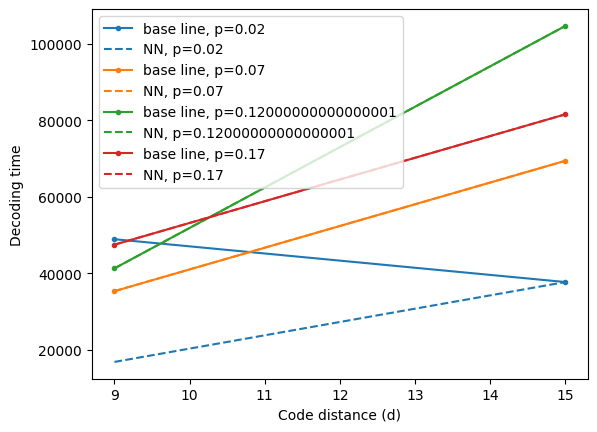

In [18]:

for i_p,p_error in enumerate(p_err_list):
    decoding_times_baseline = []
    decoding_times_parallel = []
    for i_d, d in enumerate(d_list):
        #print(logical_err_parallel)
        decoding_times_baseline.append(decoding_time_baseline[i_d,i_p]*1000000000)
        decoding_times_parallel.append(decoding_time_parallel[i_d,i_p]*1000000000)
    print(d_list)
    print("decoding_times_baseline",decoding_times_baseline)
    plt.plot(d_list,decoding_times_baseline,".-", color= f"C{i_p}",label=f"base line, p={p_error}")
    plt.plot(d_list,decoding_times_parallel,"--", color= f"C{i_p}",label=f"NN, p={p_error}")
plt.xlabel("Code distance (d)")
plt.ylabel("Decoding time")
plt.legend()
plt.show()